Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [83]:
#Importing Dependencies for all code
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
from scipy.stats import ttest_ind

In [84]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


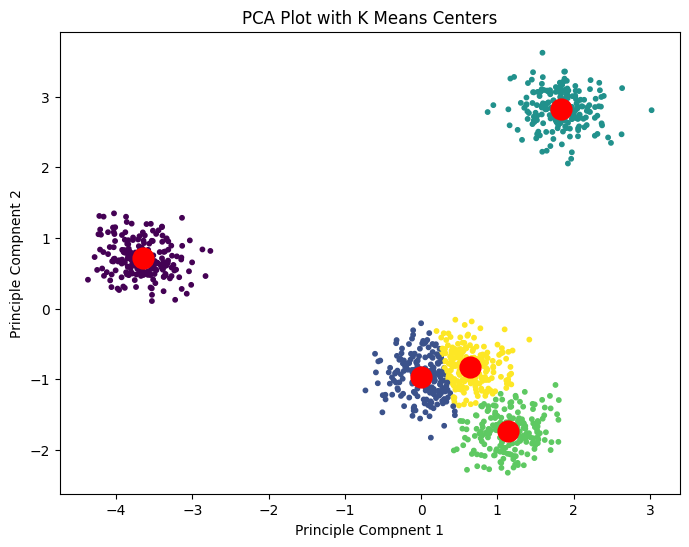

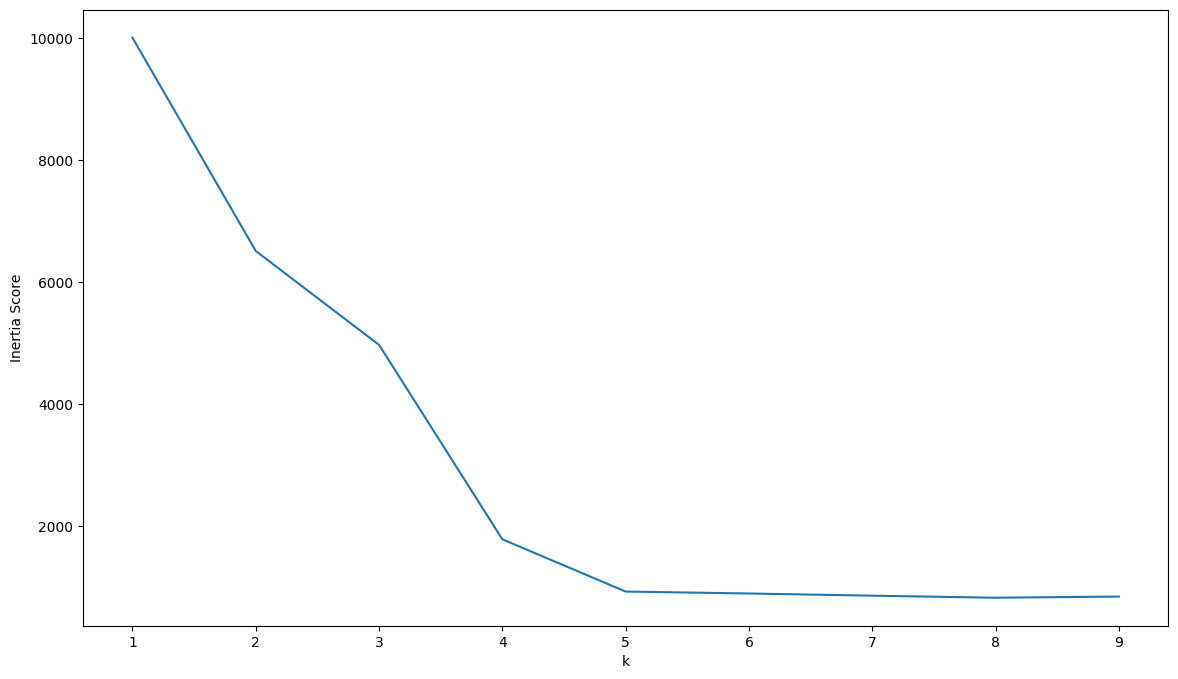

   k       inertia
0  1  10000.000000
1  2   6504.839876
2  3   4966.688280
3  4   1780.417264
4  5    924.315996
5  6    892.649540
6  7    856.624435
7  8    823.266291
8  9    842.298597


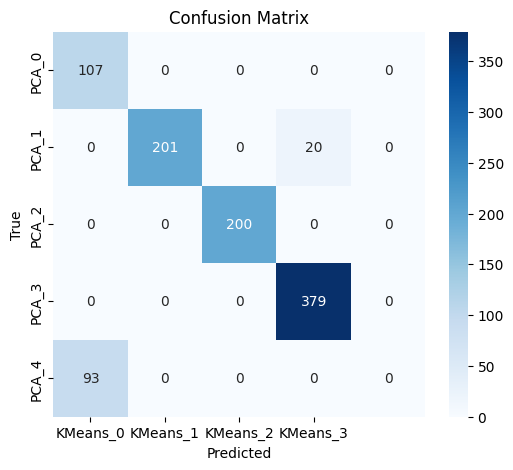

In [85]:
#PCA Clustering
X_PCA = PCA(n_components=2).fit_transform(X)

#kMean Model
kmeans_model = KMeans(init='k-means++', n_clusters=5, n_init=10, random_state=42)
kmeans_model.fit(X_PCA)

#Lables and Centers
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

#Plot PCA points colored by cluster
plt.figure(figsize=(8,6))
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=169, linewidths=3, color='red', zorder=10)
plt.title("PCA Plot with K Means Centers")
plt.xlabel("Principle Compnent 1")
plt.ylabel("Principle Compnent 2")
plt.show()

#Elbow Analysis
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    y_pred = model.fit_predict(X)
    scores.append(-model.score(X))

#Plot Elbow Curve
fig = plt.figure(figsize=(14, 8))
plt.plot(ks, scores)
plt.ylabel('Inertia Score')
plt.xlabel('k')
plt.show()

results = pd.DataFrame({"k": ks, "inertia": scores})
print(results)

#Confusion Matrix
pca_kmeans = KMeans(n_clusters=5, random_state=42)
y_true = pca_kmeans.fit_predict(X_PCA)
y_pred = kmeans_model.labels_

#Match Predictions and PCA Clusters
mapped_labels = np.zeros_like(y_pred)
for cluster in np.unique(y_pred):
    mask = (y_pred == cluster)
    mapped_labels[mask] = mode(y_true[mask], keepdims=True)[0]

cm = confusion_matrix(y_true, mapped_labels)

#Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"KMeans_{i}" for i in np.unique(mapped_labels)],
            yticklabels=[f"PCA_{i}" for i in np.unique(y_true)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [86]:
#Note OpenML went down while I was trying to complete this assignment so I used chatGPT to write the code in the cell below to obtain the dataset via another source

# import numpy as np
# from sklearn.datasets import fetch_openml
# from sklearn.preprocessing import StandardScaler

# # Load Fashion-MNIST from OpenML
# # Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
# X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
# y = y.astype(int)

# print(type(X),X.shape)
# print(type(y),y.shape)

In [87]:
#This code was written by chatGPT to obtain the dataset as openML was down

import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST directly from Keras
# Classes (0–9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Combine train and test sets
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# Flatten 28x28 images into 784-dimensional vectors
X = X.reshape(X.shape[0], -1)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


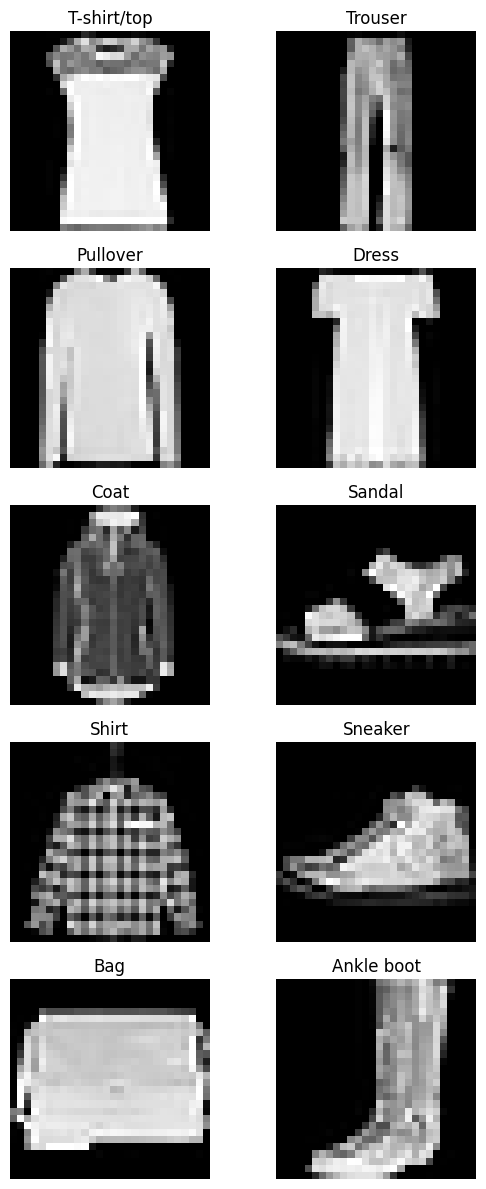

In [88]:
#Viszuliaing Dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
axes = axes.ravel()

for i in range(10):
    idx = np.random.choice(np.where(y == i)[0])
    img = X[idx].reshape(28, 28)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(class_names[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [89]:
#Sampling for Questions 2,3,4
n_samples = 2000
rng = np.random.default_rng(42)
subset_idx = rng.choice(len(X), n_samples, replace=False)
X = X[subset_idx]
y = y[subset_idx]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reduced data shape: (2000, 50)
Adjusted Rand Index: 0.35778115450377707
KMeans Inertia: 568588.7861454133


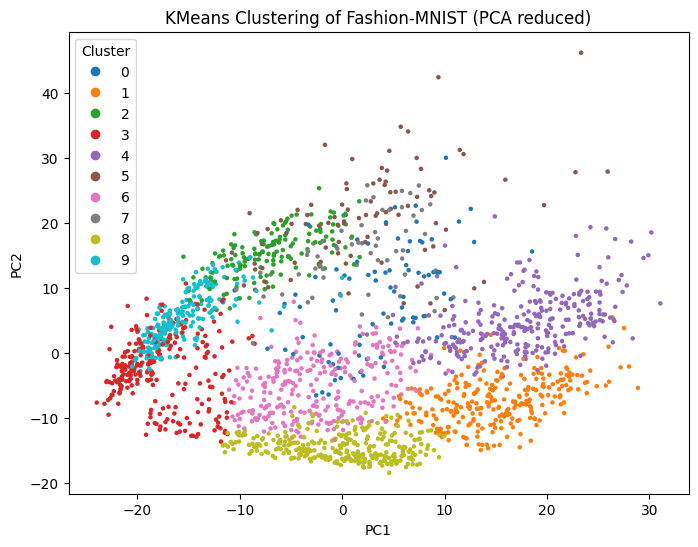

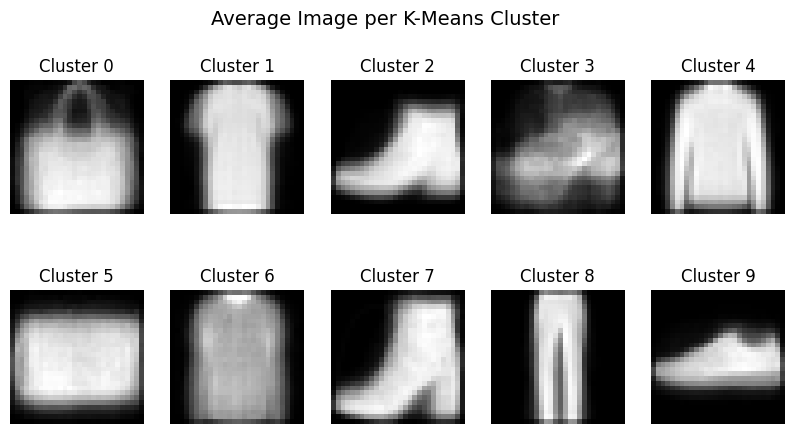

In [90]:
#PCA for visualization and KMeans
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Reduced data shape:", X_pca.shape)

k = 10
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
labels = kmeans.fit_predict(X_pca)

ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index:", ari)

print("KMeans Inertia:", kmeans.inertia_)

#Visualize using PCA
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=5)
plt.title("KMeans Clustering of Fashion-MNIST (PCA reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

#Determining Cluster Identities
cluster_means = []
for i in range(10):
    mean_img = X[labels == i].mean(axis=0).reshape(28, 28)
    cluster_means.append(mean_img)

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(cluster_means[i], cmap='gray')
    plt.title(f"Cluster {i}")
    plt.axis('off')
plt.suptitle("Average Image per K-Means Cluster", fontsize=14)
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

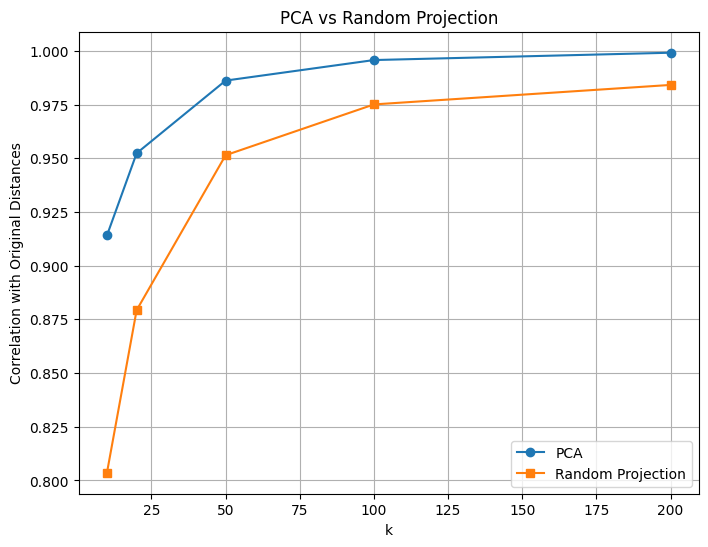

In [91]:
#Define Pairwise Distances
D_original = pairwise_distances(X_scaled, metric="euclidean")
dims = [10, 20, 50, 100, 200]
corr_pca = []
corr_rp = []

#PCA vs Random Projection over all dimensions
for k in dims:
    #PCA
    pca = PCA(n_components=k, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    D_pca = pairwise_distances(X_pca, metric="euclidean")
    corr_pca.append(np.corrcoef(D_original.ravel(), D_pca.ravel())[0,1])

    #Random Projection
    rp = GaussianRandomProjection(n_components=k, random_state=42)
    X_rp = rp.fit_transform(X_scaled)
    D_rp = pairwise_distances(X_rp, metric="euclidean")
    corr_rp.append(np.corrcoef(D_original.ravel(), D_rp.ravel())[0,1])

#Visualzie Results
plt.figure(figsize=(8,6))
plt.plot(dims, corr_pca, marker="o", label="PCA")
plt.plot(dims, corr_rp, marker="s", label="Random Projection")
plt.xlabel("k")
plt.ylabel("Correlation with Original Distances")
plt.title("PCA vs Random Projection")
plt.legend()
plt.grid(True)
plt.show()


# 4. Clustering Fashion-MNIST using spectral clustering

Adjusted Rand Index: 0.3774278100723756


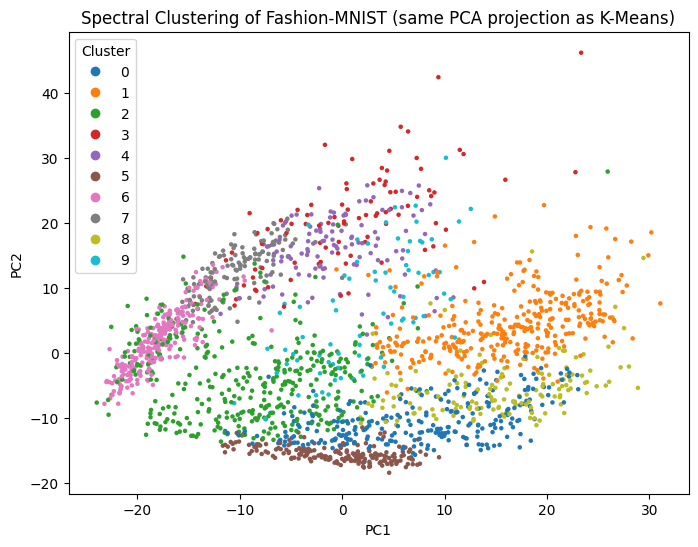

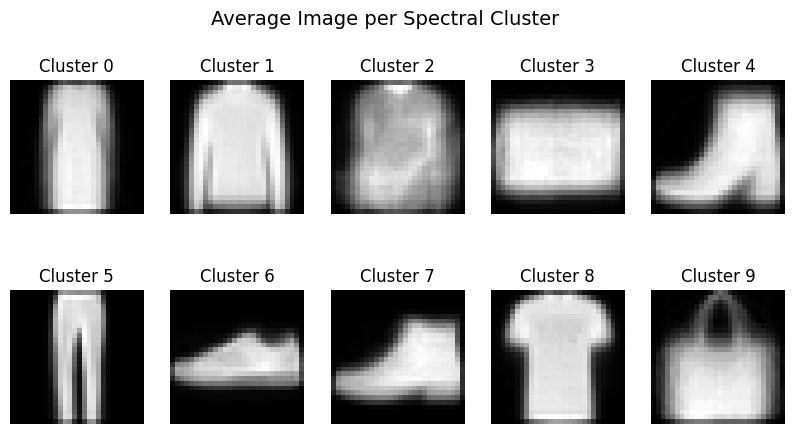

In [92]:
#Spectral Clustering
k = 10
spectral = SpectralClustering(
    n_clusters=k,
    eigen_solver='arpack',
    affinity='nearest_neighbors',
    n_neighbors=15,
    assign_labels='kmeans',
    random_state=42
)
labels_spec = spectral.fit_predict(X_pca)

ari = adjusted_rand_score(y, labels_spec)
print("Adjusted Rand Index:", ari)

#Visualzie
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_spec, cmap="tab10", s=5)
plt.title("Spectral Clustering of Fashion-MNIST (same PCA projection as K-Means)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

#Determining Cluster Identities
cluster_means = []
for i in range(k):
    mean_img = X[labels_spec == i].mean(axis=0).reshape(28, 28)
    cluster_means.append(mean_img)

plt.figure(figsize=(10,5))
for i in range(k):
    plt.subplot(2,5,i+1)
    plt.imshow(cluster_means[i], cmap='gray')
    plt.title(f"Cluster {i}")
    plt.axis('off')
plt.suptitle("Average Image per Spectral Cluster", fontsize=14)
plt.show()

In [93]:
#Code to test signifigance between ARI of kmeans vs spectral clustering

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

#Run 30 Trials of kmeans vs spectral clustering
n_runs = 30
kmeans_ari = []
spectral_ari = []

for seed in range(n_runs):
    #KMeans
    kmeans = KMeans(n_clusters=10, n_init=10, random_state=seed)
    kmeans_labels = kmeans.fit_predict(X_pca)
    ari_k = adjusted_rand_score(y, kmeans_labels)
    kmeans_ari.append(ari_k)

    #Spectral Clustering
    spectral = SpectralClustering(
        n_clusters=10,
        assign_labels="kmeans",
        random_state=seed,
        affinity="nearest_neighbors",
        n_neighbors=10
    )
    spectral_labels = spectral.fit_predict(X_pca)
    ari_s = adjusted_rand_score(y, spectral_labels)
    spectral_ari.append(ari_s)

#Two-Sample t-test
t_stat, p_value = ttest_ind(kmeans_ari, spectral_ari, equal_var=False)

print("KMeans ARI scores:", np.round(kmeans_ari, 4))
print("Spectral ARI scores:", np.round(spectral_ari, 4))
print(f"\nTwo-sample t-test:")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p_value:.4e}")

if p_value < 0.05:
    print("Significant difference between KMeans and Spectral Clustering (reject null)")
else:
    print("No significant difference (fail to reject null)")

KMeans ARI scores: [0.3319 0.3578 0.3586 0.3589 0.3417 0.3372 0.3578 0.3597 0.3467 0.3433
 0.3577 0.3605 0.3433 0.3585 0.3421 0.3578 0.3605 0.3589 0.332  0.3591
 0.3418 0.3309 0.3578 0.3597 0.3607 0.3422 0.3583 0.3578 0.3584 0.3305]
Spectral ARI scores: [0.4093 0.4093 0.4093 0.4093 0.4093 0.4093 0.4093 0.4091 0.4098 0.4093
 0.4107 0.4093 0.4091 0.4093 0.4093 0.4098 0.4093 0.4098 0.4093 0.4093
 0.4093 0.4093 0.4093 0.4093 0.4093 0.4093 0.4091 0.4098 0.4093 0.4093]

Two-sample t-test:
t-statistic = -29.9932
p-value = 2.0670e-23
Significant difference between KMeans and Spectral Clustering (reject null)
